In [30]:
import pandas as pd

data = pd.read_csv("bike_daily.csv")
data.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [31]:
data.isnull().sum()


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Aucune valeur manquante

In [20]:
print(data.dtypes)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


Clairement, season, month week day, year, holiday, sont des variables catégorielles même si ce sont des nombres. On va faire PCA sur les variables temp, atemp, hum, windspeed. 
On va traiter les variables continues. On va quand même faire aussi l'analyse factorielle parce que season, yr, month peuvent quand même être incluse dans un neural network. 

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np


X = data[["temp", "atemp", "hum", "windspeed"]]
X.describe()

,temp,atemp,hum,windspeed
count,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486
std,0.183051,0.162961,0.142429,0.077498
min,0.059130,0.079070,0.000000,0.022392
25%,0.337083,0.337842,0.520000,0.134950
50%,0.498333,0.486733,0.626667,0.180975
75%,0.655417,0.608602,0.730209,0.233214
max,0.861667,0.840896,0.972500,0.507463


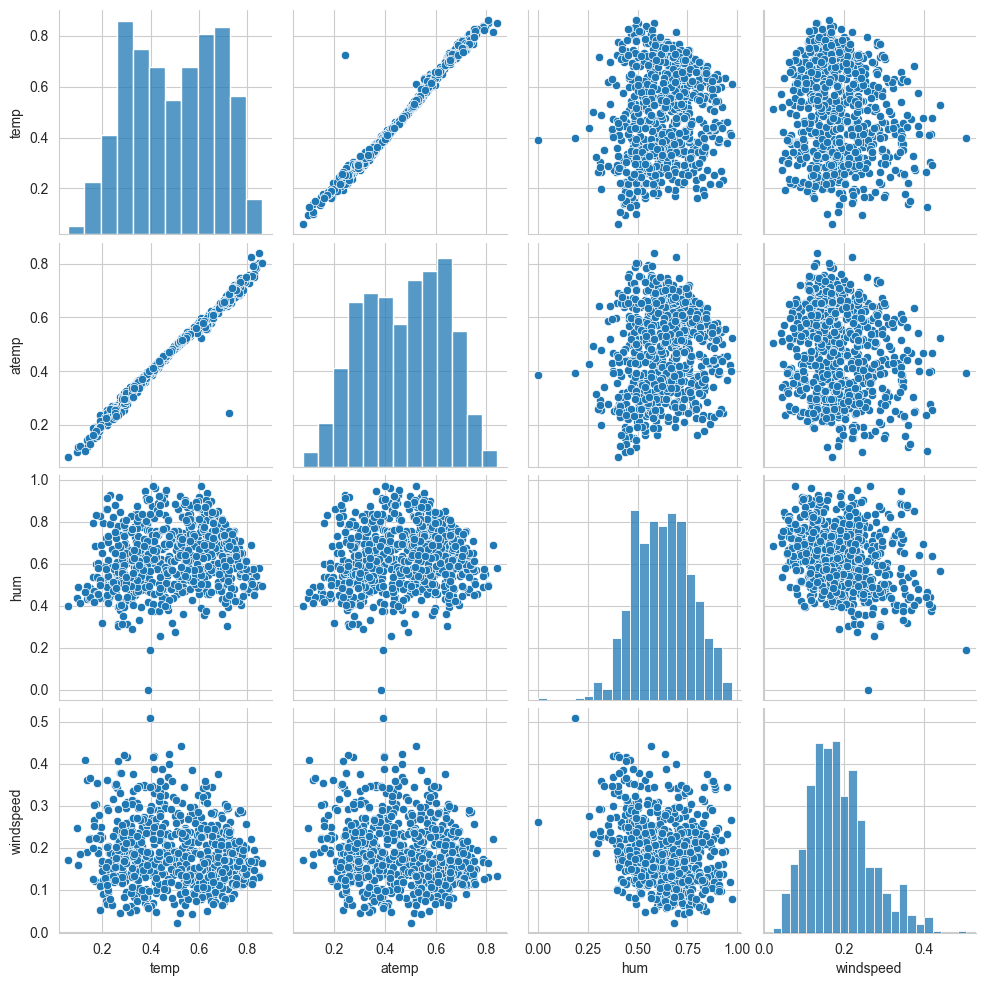

In [33]:
import seaborn as sns

sns.pairplot(X)
plt.show()

Clairement, atemp et temp sont corrélé positivement.Pour le reste, c'est inscertain. 

<Figure size 1000x600 with 0 Axes>

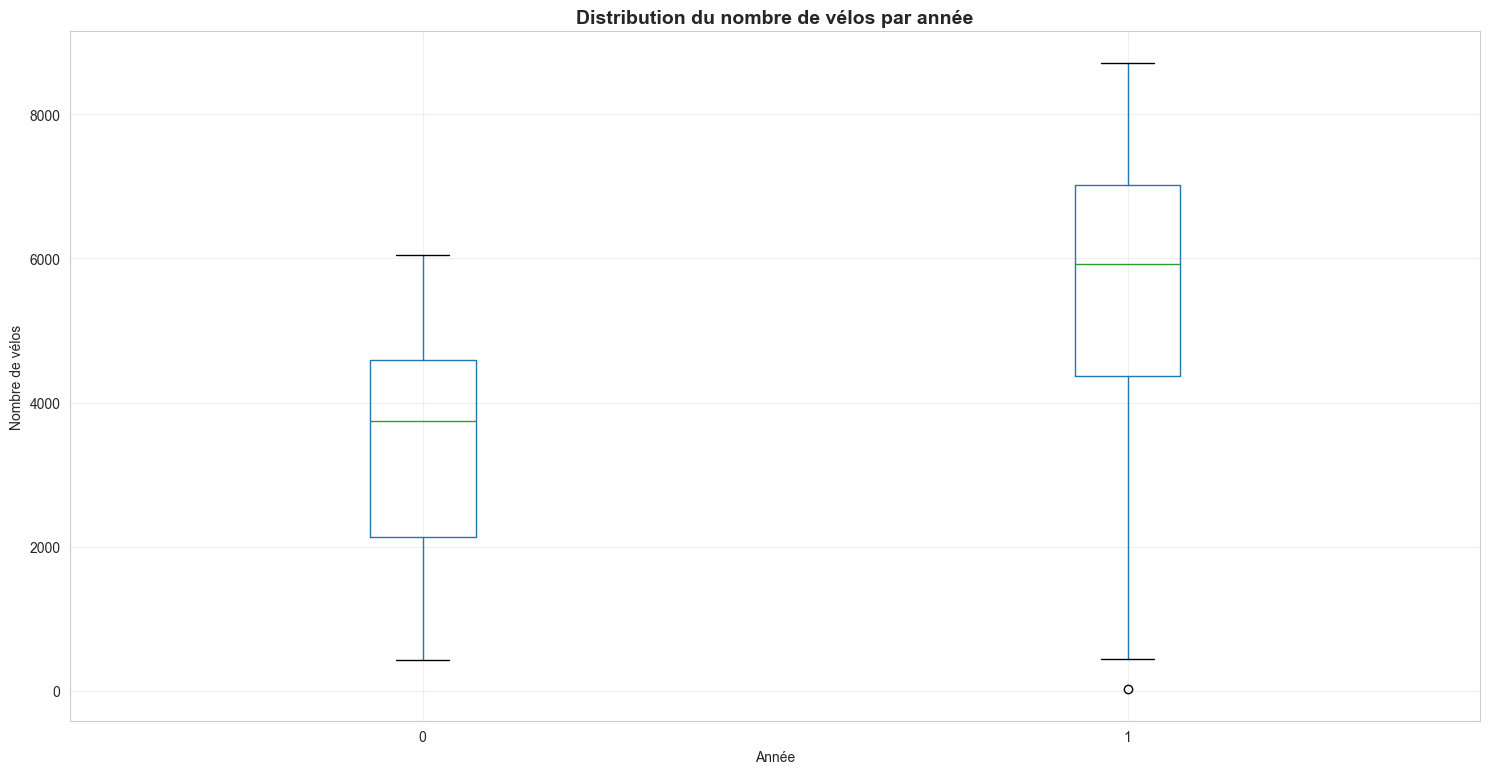

In [40]:
plt.figure(figsize=(10, 6))
data.boxplot(column='cnt', by='yr')
plt.suptitle('')  # Enlever le titre automatique
plt.title('Distribution du nombre de vélos par année', fontsize=14, fontweight='bold')
plt.xlabel('Année')
plt.ylabel('Nombre de vélos')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

L'année est aussi un paramètre à prendre en compte pour prédire le nombre de vélo. 

,temp,atemp,hum,windspeed
0,0.344167,0.363625,0.805833,0.160446
1,0.363478,0.353739,0.696087,0.248539
2,0.196364,0.189405,0.437273,0.248309
3,0.200000,0.212122,0.590435,0.160296
4,0.226957,0.229270,0.436957,0.186900
...,...,...,...,...
726,0.254167,0.226642,0.652917,0.350133
727,0.253333,0.255046,0.590000,0.155471
728,0.253333,0.242400,0.752917,0.124383
729,0.255833,0.231700,0.483333,0.350754


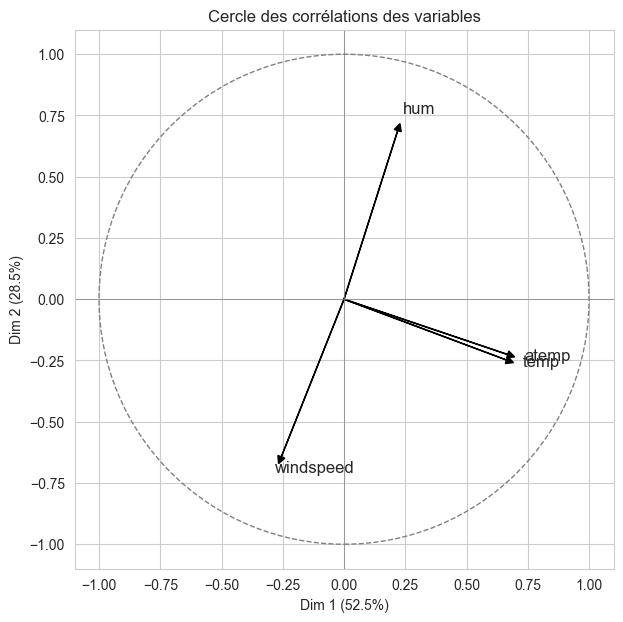

In [44]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)

pca.fit(X_scaled)
components = pca.components_.T  

fig, ax = plt.subplots(figsize=(7,7))

circle = plt.Circle((0,0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)

for i, var in enumerate(X.columns):
    x = components[i, 0]
    y = components[i, 1]
    ax.arrow(0, 0, x, y, 
             head_width=0.03, 
             head_length=0.03, 
             linewidth=1, 
             color="black")
    ax.text(x * 1.1, y * 1.1, var, fontsize=12)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f"Dim 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"Dim 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("Cercle des corrélations des variables")
ax.axhline(0, color='grey', linewidth=0.5)
ax.axvline(0, color='grey', linewidth=0.5)
ax.set_aspect('equal')

plt.show()

On voit que atemp et temp sont fortement corrélé et représente les vecteurs qui représente le mieux la dimension principale. Tandis que windspeed et humidité sont corrélé négativement avec des flèches dont l'angle est proche de 180°. 

C:\Users\enzom\AppData\Local\Temp\ipykernel_21332\1711461745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_factor[col] = X_factor[col].astype("category")
C:\Users\enzom\AppData\Local\Temp\ipykernel_21332\1711461745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_factor[col] = X_factor[col].astype("category")
C:\Users\enzom\AppData\Local\Temp\ipykernel_21332\1711461745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

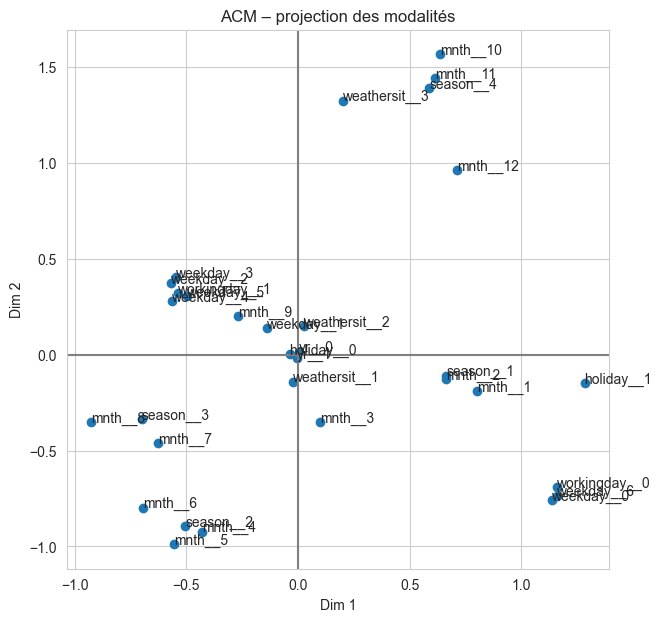

In [ ]:
import prince

X_factor = data[["yr", "season", "mnth", "holiday",
                 "weekday", "workingday", "weathersit"]]

# Convertir en catégories
for col in X_factor.columns:
    X_factor[col] = X_factor[col].astype("category")

# ACM avec engine correct
mca = prince.MCA(
    n_components=2,
    n_iter=5,
    engine='sklearn', 
    random_state=42
)

mca = mca.fit(X_factor)

coords = mca.column_coordinates(X_factor)

fig, ax = plt.subplots(figsize=(7, 7))

coords = mca.column_coordinates(X_factor)

ax.scatter(coords[0], coords[1])

for i, txt in enumerate(coords.index):
    ax.annotate(txt, (coords.iloc[i,0], coords.iloc[i,1]))

plt.axhline(0, color="grey")
plt.axvline(0, color="grey")
plt.title("ACM – projection des modalités")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()



On voit nettement des clusters. season_4 est proche de mnth_11 mnth_12... season_4 est l'hiver. Pour éviter d'avoir un cercle de corélation trop dense, on va supprimer de l'analyse factorielle les mois et garder uniquement les saisons. 

C:\Users\enzom\AppData\Local\Temp\ipykernel_21332\2040214358.py:90: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


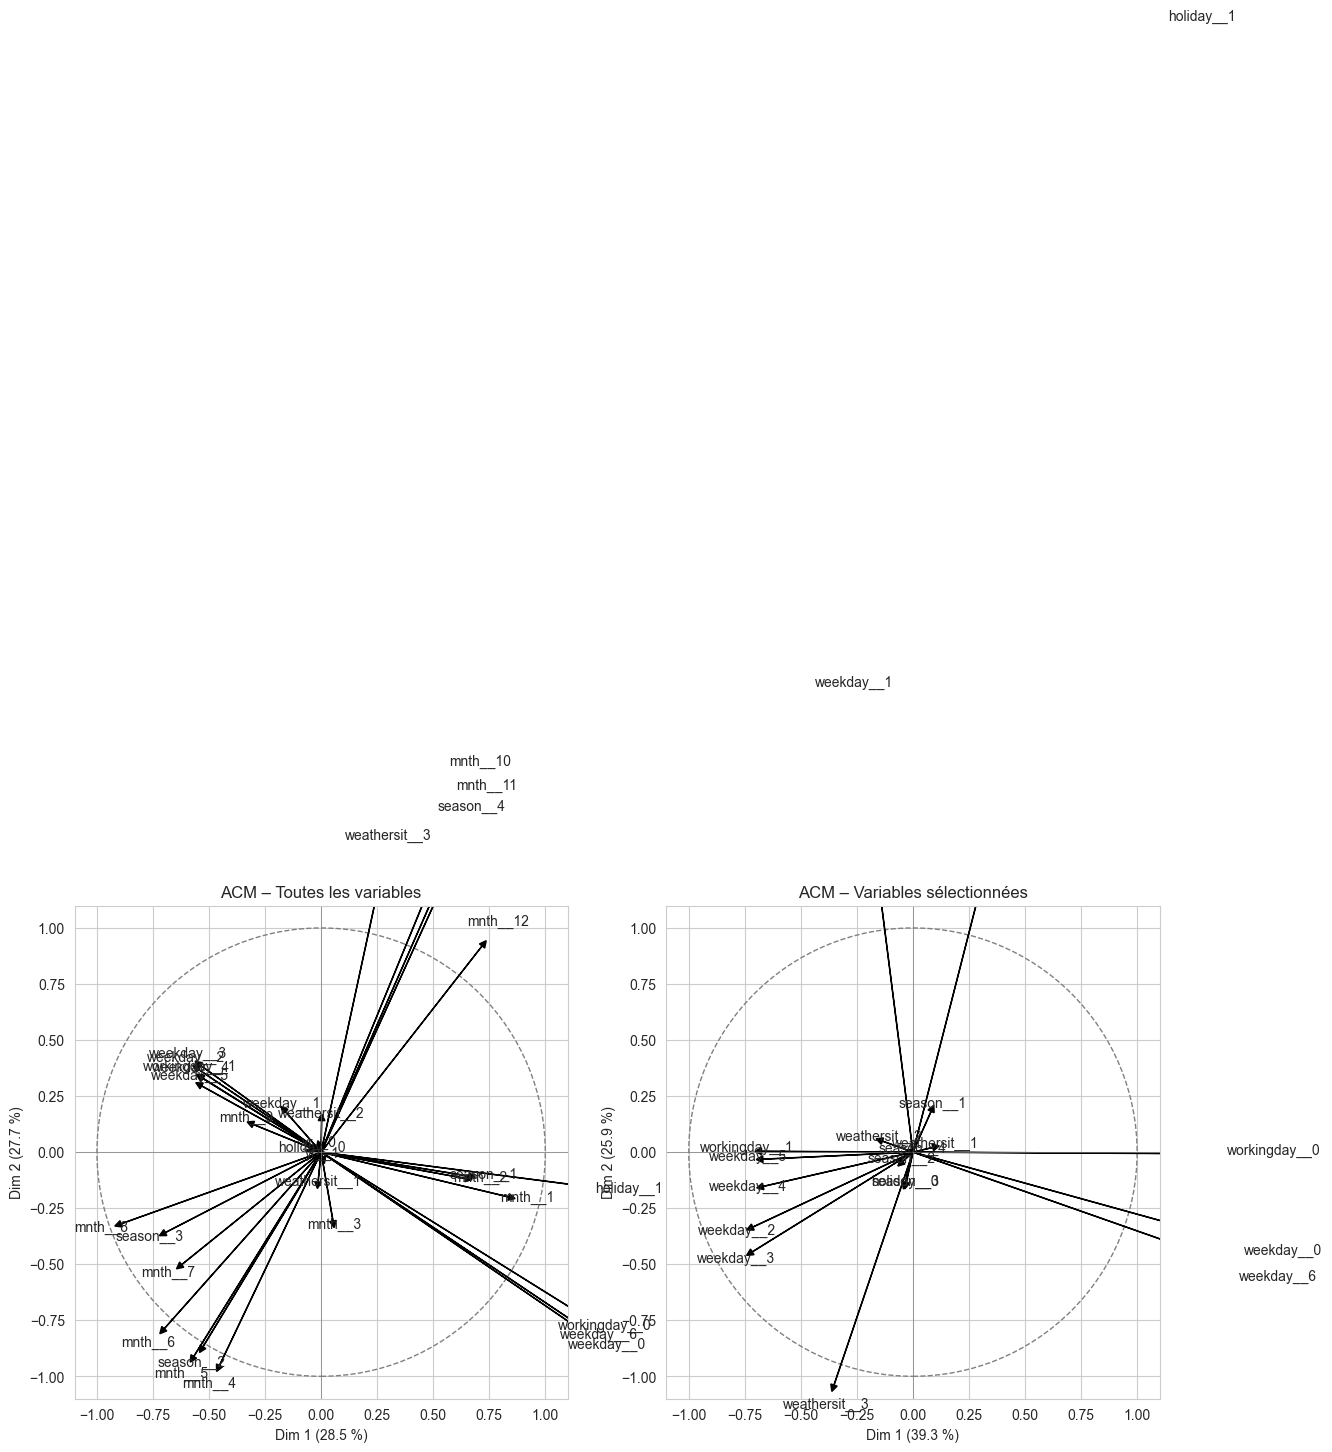

In [42]:
variables_categorielles = [
    "season", "holiday",
    "weekday", "workingday", "weathersit", "mnth", "yr"
]
variables_cat2 = [
    "season", "holiday",
    "weekday", "workingday", "weathersit"
]

X_factor = data[variables_categorielles].copy()
X_factor = X_factor.astype("category")

X_factor2 = data[variables_cat2].copy()
X_factor2 = X_factor2.astype("category")

mca = prince.MCA(
    n_components=2,
    n_iter=5,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca.fit(X_factor)

mca2 = prince.MCA(
    n_components=2,
    n_iter=5,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca2.fit(X_factor2)

coords = mca.column_coordinates(X_factor)
inertia = mca.eigenvalues_
dim1, dim2 = inertia[0], inertia[1]

coords2 = mca2.column_coordinates(X_factor2)
inertia2 = mca2.eigenvalues_
dim1_2, dim2_2 = inertia2[0], inertia2[1]

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

cercle1 = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax[0].add_artist(cercle1)

for modalite, (x, y) in coords.iterrows():
    ax[0].arrow(
        0, 0, x, y,
        head_width=0.03,
        head_length=0.03,
        linewidth=1,
        color="black"
    )
    ax[0].text(x * 1.1, y * 1.1, modalite, fontsize=10, ha='center')

ax[0].set_xlim(-1.1, 1.1)
ax[0].set_ylim(-1.1, 1.1)
ax[0].set_xlabel(f"Dim 1 ({dim1 * 100:.1f} %)")
ax[0].set_ylabel(f"Dim 2 ({dim2 * 100:.1f} %)")
ax[0].set_title("ACM – Toutes les variables")
ax[0].axhline(0, color='grey', linewidth=0.5)
ax[0].axvline(0, color='grey', linewidth=0.5)
ax[0].set_aspect('equal')

cercle2 = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax[1].add_artist(cercle2)

for modalite, (x, y) in coords2.iterrows():
    ax[1].arrow(
        0, 0, x, y,
        head_width=0.03,
        head_length=0.03,
        linewidth=1,
        color="black"
    )
    ax[1].text(x * 1.1, y * 1.1, modalite, fontsize=10, ha='center')

ax[1].set_xlim(-1.1, 1.1)
ax[1].set_ylim(-1.1, 1.1)
ax[1].set_xlabel(f"Dim 1 ({dim1_2 * 100:.1f} %)")
ax[1].set_ylabel(f"Dim 2 ({dim2_2 * 100:.1f} %)")
ax[1].set_title("ACM – Variables sélectionnées")
ax[1].axhline(0, color='grey', linewidth=0.5)
ax[1].axvline(0, color='grey', linewidth=0.5)
ax[1].set_aspect('equal')

plt.tight_layout()
plt.show()

J'ai commencé mon approche en enlevant les features contenant l'année et les mois. Nous avons obtenu le cercle de corrélation de droite. Nous avons dans un premier temps analysé que la composante principale capte essentiellement la variabilité comprise dans workingday = False. L’axe 2 oppose :
des jours particuliers (lundi, jour férié) à des situations de météo très dégradée (weathersit_3). Les deux axes représentent 65,2% de l’inertie, soit une bonne représentation globale pour une ACM. Si on veut par la suite éliminer ou ajouter des variables catégorielles dans notre modèle mais pas trop, on pourrait tester avec un set de variables non corrélés. On va essayer une régression linéaire simple avec les variables catégorielles : workingday et weathersit même si weathersit est potentielement fortement corrélé aux données quantitatives de vent, d'humidité et de température. Si les p_values sont faibles. On les incluera dans le modèle. Prendre holiday et working day même s'ils apparraissent décorrélé sur le cercle, on sait en pratique qu'ils sont fortement corrélés. 

En plottant le cercle de corrélation avec l'ensemble des features catégorielles, on a désormais plus le problème avec les features holiday et working day qui apparaisse plus corrélé. On dégage mieux le fait qu'il y ait un groupe [bad weather, mois de l'hiver] et à l'opposé [good weather, mois d'été] et perpendiculairement, les jours travaillés et les jours non travaillé. 

In [27]:
contingence = pd.crosstab(data["holiday"], data["workingday"],
                   rownames=["holiday"],
                   colnames=["workingday"])

print(contingence)

workingday    0    1
holiday             
0           210  500
1            21    0


Comme on le voit sur la matrice de contingence on ne peut pas travailler et être en vacances. Le cas contraire aurait remis en question l'intégrité de la base de donnée. 

In [51]:
import statsmodels.api as sm

y = data["cnt"]
test_cat = ["weathersit", "workingday", 'yr']

X_categories = X_factor.loc[:,test_cat]
x = pd.get_dummies(X_categories, drop_first=True)

x = x.astype(int)
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     123.8
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.54e-80
Time:                        09:34:42   Log-Likelihood:                -6379.6
No. Observations:                 731   AIC:                         1.277e+04
Df Residuals:                     726   BIC:                         1.279e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3570.1233    119.741     29.815   

Le modèle de régression linéaire avec les variables catégorielles démontre que pour les features catégorielles choisient (year, condition météo, year) expliquent en parti le nombre de vélos utilisés au total. (p_values < 0.05)

In [70]:
X_scaled = X_scaled[:, [0, 2, 3]]

On supprime atemp

In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split 
import lightning as pl
from lightning.pytorch.utilities.model_summary import ModelSummary
from simplelogger import SimpleLogger


y = data["cnt"]
y = y.values.reshape(-1, 1)

X_categories = X_factor.loc[:, test_cat]
x_cat = pd.get_dummies(X_categories, drop_first=True)
#On enlève les premières modalités pour éviter la redondance dans les variables catégorielles : workingday_1 + workingday_0 = 1
print(x_cat.head())
X_final = pd.concat([pd.DataFrame(X_scaled), x_cat.reset_index(drop=True)], axis=1)
X_final = X_final.astype(float)

print("Données finales :")
print(X_final.head())
print(f"Shape : {X_final.shape}")

stratify_columns = data[["weathersit", "workingday", 'yr']]

x_train, x_test, y_train, y_test = train_test_split(
    X_final.values,
    y,
    stratify=stratify_columns,
    test_size=0.2,
    random_state=123
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"\nx_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"y_test shape : {y_test.shape}")

   weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  season_2  \
0      False      False      False      False      False       True     False   
1      False      False      False      False      False      False     False   
2       True      False      False      False      False      False     False   
3      False       True      False      False      False      False     False   
4      False      False       True      False      False      False     False   

   season_3  season_4   yr_1  
0     False     False  False  
1     False     False  False  
2     False     False  False  
3     False     False  False  
4     False     False  False  
Données finales :
          0         1         2  weekday_1  weekday_2  weekday_3  weekday_4  \
0 -0.826662  1.250171 -0.387892        0.0        0.0        0.0        0.0   
1 -0.721095  0.479113  0.749602        0.0        0.0        0.0        0.0   
2 -1.634657 -1.339274  0.746632        1.0        0.0        0.0        

 ## Model Definition

In [90]:
x_train.shape[1]
y_train.shape[1]

1

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | activation | ReLU       | 0      | train
1 | layers     | Sequential | 4.7 K  | train
2 | mse        | MSELoss    | 0      | train
--------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


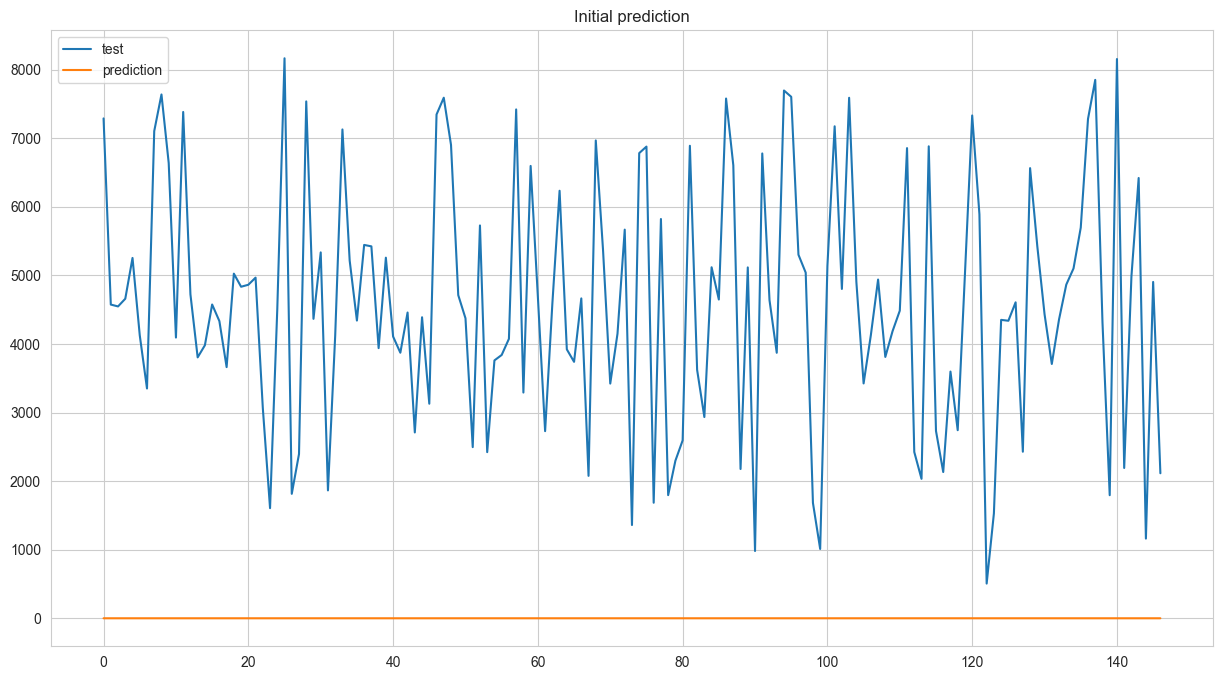

In [131]:
class Bike_model(pl.LightningModule):
    def __init__(self, input_dim, lr=1e-3):
        super(Bike_model, self).__init__()
        self.activation = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(13, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   
        )
        self.mse = nn.MSELoss()
        self.lr = lr

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.layers(x)
        loss = self.mse(yhat, y)
        self.log(f"train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.mse(yhat, y)
        self.log(f"val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)

model = Bike_model(x_train.shape[1], lr=1e-4)
summary = ModelSummary(model)
print(summary)
plt.plot(y_test, label="test")
plt.plot(model(x_test).detach(), label="prediction")
plt.title("Initial prediction")
plt.legend()

 ## Train the Model

In [135]:
trainer = pl.Trainer(
    max_epochs=50,
    logger=SimpleLogger(),
    enable_checkpointing=False,
    log_every_n_steps=1,
)  # logger=False, enable_checkpointing=False to avoid polluting your workspace with lightning_logs and checkpoints

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [136]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)


  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | activation | ReLU       | 0      | train
1 | layers     | Sequential | 4.7 K  | train
2 | mse        | MSELoss    | 0      | train
--------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 73/73 [00:00<00:00, 101.33it/s, v_num=Data, val_loss=9.79e+5, train_loss=9.44e+5]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 73/73 [00:00<00:00, 100.94it/s, v_num=Data, val_loss=9.79e+5, train_loss=9.44e+5]


 ## Evaluate Model

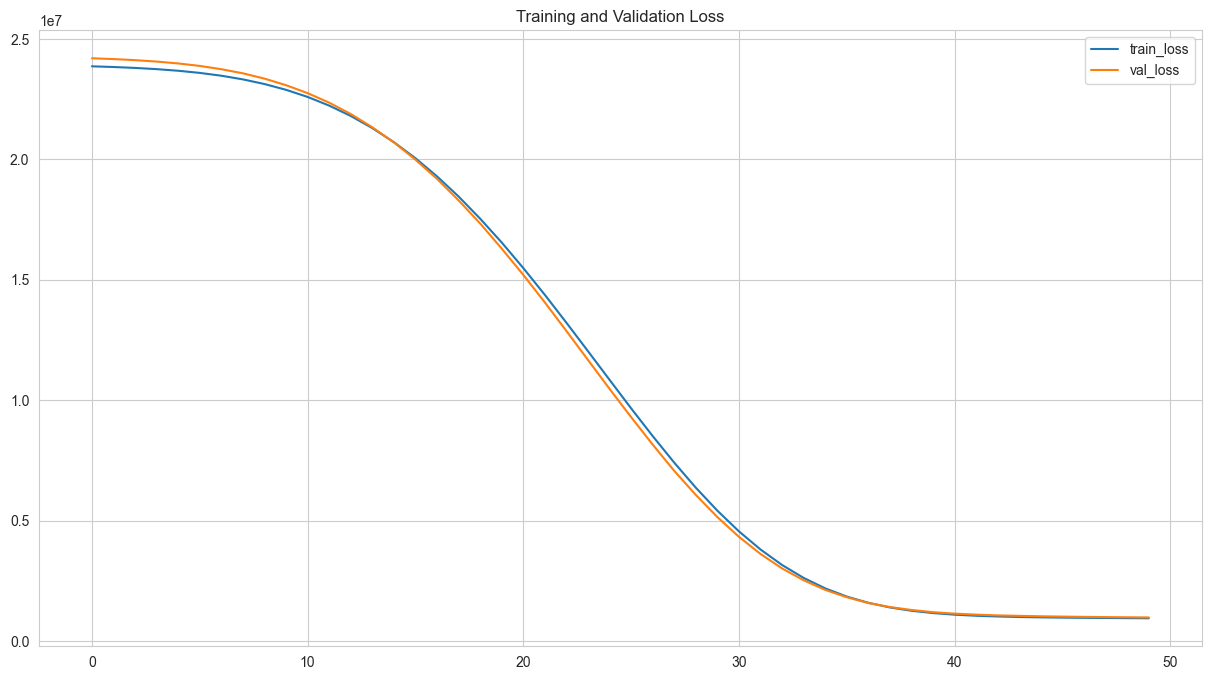

In [138]:
plt.plot(trainer.logger.metrics["train_loss"], label="train_loss")
plt.plot(trainer.logger.metrics["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.legend()

Ici on représente la MSE au fur et à mesure des epoch. On voit que les améliorations du modèle  sont minim après 50 epoch, on diminuera le nombre d'epoch par la suite. Il nous reste encore à compter les prédictions mal classé. 

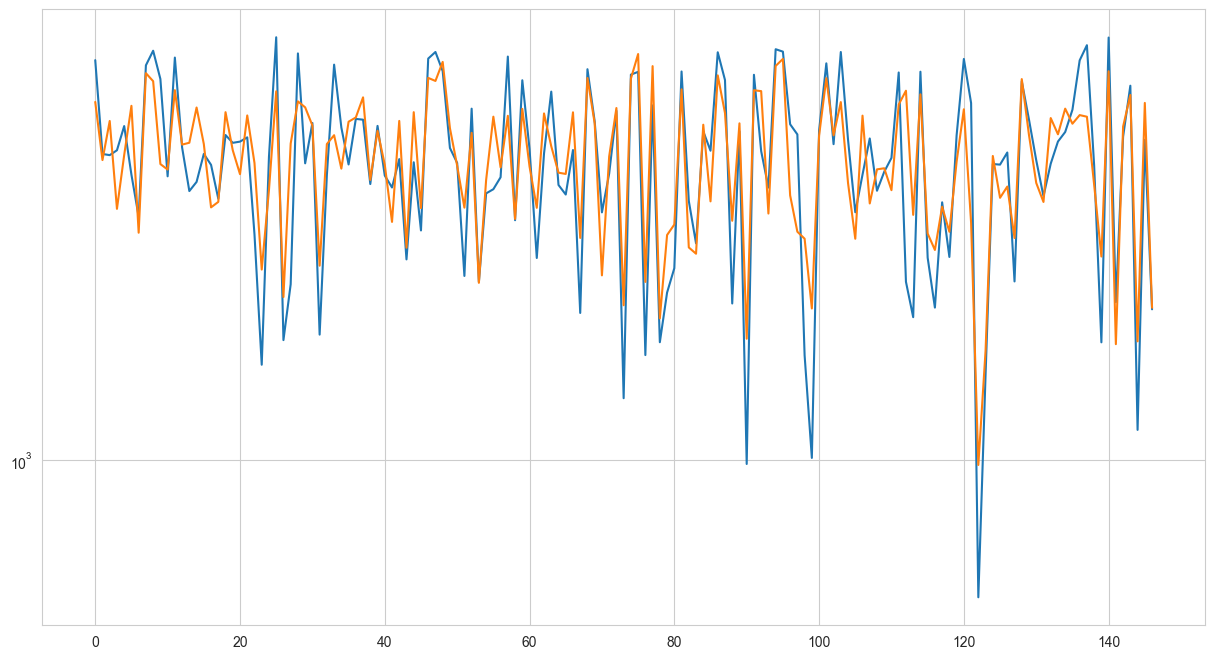

In [139]:
plt.plot(y_test)
plt.plot(model(x_test).detach())
plt.yscale("log")
plt.show()


Prédiction du modèle sur les données test. Il y a un bon suivi des tendances même dans les parties les moins linéaires.


Text(0.5, 1.0, 'Matrice de confusion (seuil=4000)')

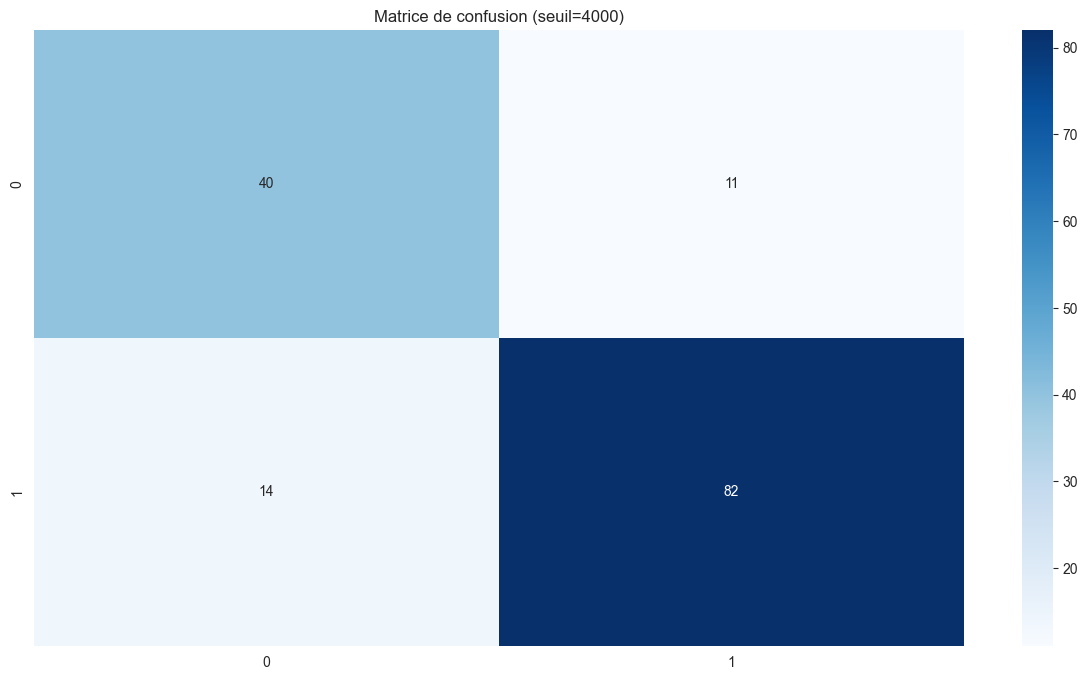

In [140]:
from sklearn.metrics import confusion_matrix
y_pred = model(x_test).detach().numpy().flatten()

# Binariser avec seuil 4000
y_test_bin = (y_test.numpy() >= 4000).astype(int)
y_pred_bin = (y_pred >= 4000).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion (seuil=4000)")

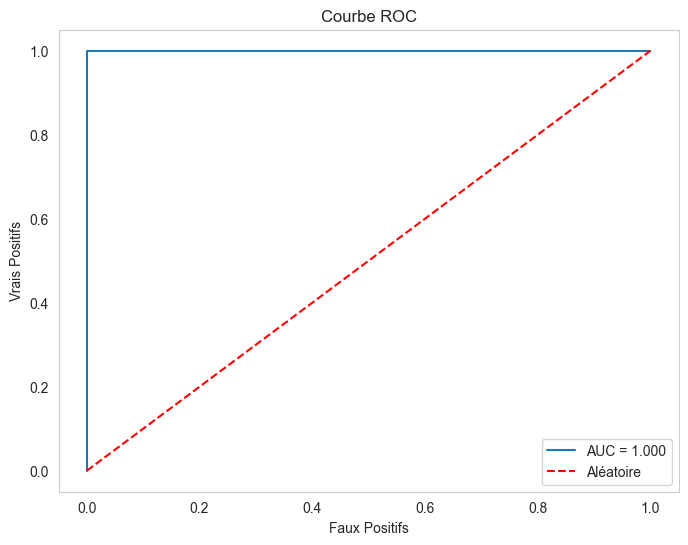

Score AUC: 1.000


In [141]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Prédictions
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x, y in test_loader:
        predictions.append(model(x))
        actuals.append(y)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()



# Classes binaires (>4000 = 1, sinon 0)
actual_class = (predictions > 4000).astype(int)

# Courbe ROC
fpr, tpr, thresholds = roc_curve(actual_class, predictions)
auc_score = auc(fpr, tpr)

# Graphique
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'r--', label='Aléatoire')
plt.xlabel('Faux Positifs')
plt.ylabel('Vrais Positifs')
plt.title('Courbe ROC')
plt.legend()
plt.grid()
plt.show()

print(f"Score AUC: {auc_score:.3f}")

On obtient des résultats parfaits

Dans un second temps on décide d'entraîner 2 RNN différents parce que dans nos données d'entraînement on fait la distinction entre le nombre d’usagers à la fois abonnés et non abonnés.

Le mieux : faire des courches pour évaluer y_1 et y_2 et après une couche y_final = somme des 2 sigma(supérieur pu inférieur à 4000). 

In [94]:
y = data[["registered", "casual"]]
y = y.values.reshape((-1,2))
X_categories = X_factor.loc[:, test_cat]
x_cat = pd.get_dummies(X_categories, drop_first=True)
#On enlève les premières modalités pour éviter la redondance dans les variables catégorielles : workingday_1 + workingday_0 = 1

X_final = pd.concat([pd.DataFrame(X_scaled), x_cat.reset_index(drop=True)], axis=1)
X_final = X_final.astype(float)

x_train, x_test, y_train, y_test = train_test_split(
    X_final.values,
    y,
    stratify=stratify_columns,
    test_size=0.2,
    random_state=123
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [96]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("x_train shape:", x_train.shape)
print("x_test shape :", x_test.shape)


x_train shape: torch.Size([584, 13])
x_test shape : torch.Size([147, 13])


In [ ]:
class bikemodel_2_output(pl.LightningModule):
    def __init__(self, input_dim, lr=1e-3):
        super(bikemodel_2_output, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)   # deux sorties : casual, registered
        )
        self.mse = nn.MSELoss()
        self.lr = lr
    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.layers(x)
        loss = self.mse(yhat, y)
        mae = (yhat - y).abs().mean(1)
        self.log(f"train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.mse(yhat, y)
        self.log(f"val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)

model = bikemodel_2_output(x_train.shape[1], lr=1e-4)
summary = ModelSummary(model)
print(summary)

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | activation | ReLU       | 0      | train
1 | layers     | Sequential | 4.7 K  | train
2 | mse        | MSELoss    | 0      | train
--------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


In [105]:
trainer = pl.Trainer(
    max_epochs=150,
    logger=SimpleLogger(),
    enable_checkpointing=False,
    log_every_n_steps=1,
)  # logger=False, enable_checkpointing=False to avoid polluting your workspace with lightning_logs and checkpoints

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Avec seulement 50 epoch ça n'a pas entraîner assez.

In [106]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)


  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | activation | ReLU       | 0      | train
1 | layers     | Sequential | 4.7 K  | train
2 | mse        | MSELoss    | 0      | train
--------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 73/73 [00:00<00:00, 89.64it/s, v_num=Data, val_loss=4.46e+5, val_mae=4.46e+5, train_loss=4.41e+5, train_mae=4.41e+5] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 73/73 [00:00<00:00, 89.39it/s, v_num=Data, val_loss=4.46e+5, val_mae=4.46e+5, train_loss=4.41e+5, train_mae=4.41e+5]


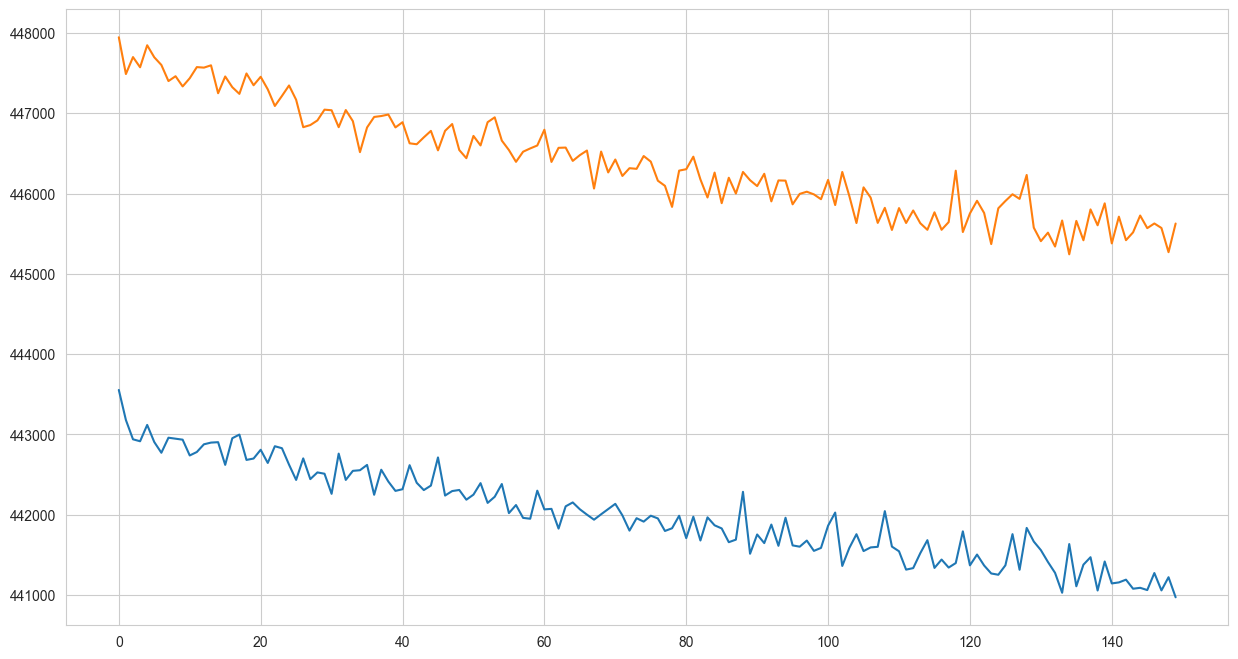

In [107]:

plt.plot(trainer.logger.metrics["train_loss"])
plt.plot(trainer.logger.metrics["val_loss"])
plt.show()

Même avec 150 epochs ça ne converge pas, on en déduit que lorsqu'on a 2 outputs à prédire le modèle n,nécessite beaucoup plus d'itérations pour apprendre. 

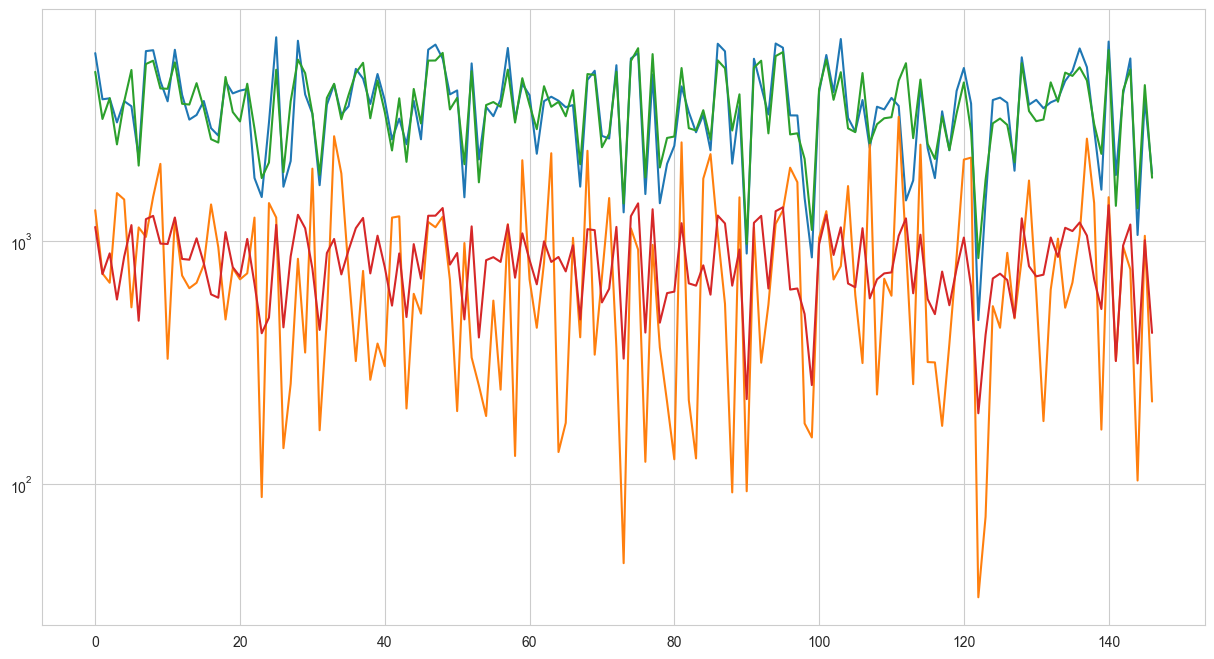

In [108]:
plt.plot(y_test)
plt.plot(model(x_test).detach())
plt.yscale("log")
plt.show()


Les prédictions sur registered sont meilleurs que sur casual qui doit sûrement avoir plus de variance. 

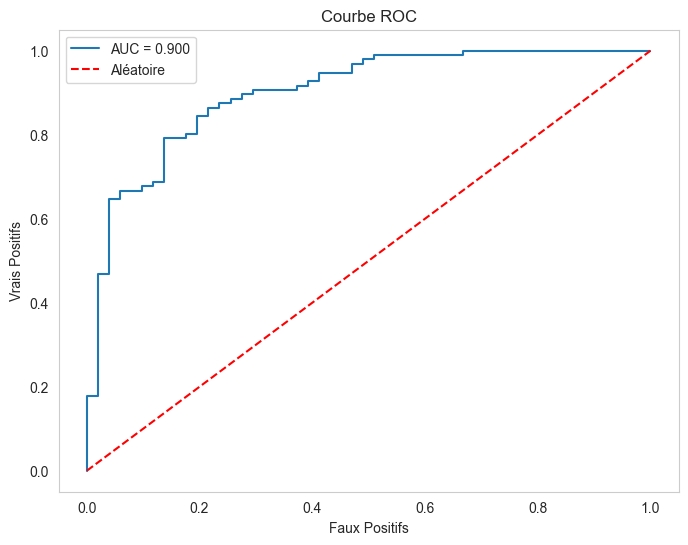

Score AUC: 0.900


In [109]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Prédictions
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x, y in test_loader:
        predictions.append(model(x))
        actuals.append(y)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()

# Total vélos (somme des 2 colonnes)
pred_total = predictions[:, 0] + predictions[:, 1]
actual_total = actuals[:, 0] + actuals[:, 1]

# Classes binaires (>4000 = 1, sinon 0)
actual_class = (actual_total > 4000).astype(int)

# Courbe ROC
fpr, tpr, thresholds = roc_curve(actual_class, pred_total)
auc_score = auc(fpr, tpr)

# Graphique
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'r--', label='Aléatoire')
plt.xlabel('Faux Positifs')
plt.ylabel('Vrais Positifs')
plt.title('Courbe ROC')
plt.legend()
plt.grid()
plt.show()

print(f"Score AUC: {auc_score:.3f}")

# Question 3

Au lieu de faire une prédiction et après classer on peut directement entraîner le modèle pour qu'il classe en utilisant la fonction coût Binary Cross Entropy utile pour la classification binaire. La MSE n'a plus de sens à être utilisé.

In [ ]:
y_binary = (data["cnt"] > 4000).astype(int)  # 1 si >4000, 0 sinon
y = y_binary.values.reshape(-1, 1) 


X_categories = X_factor.loc[:, test_cat]
x_cat = pd.get_dummies(X_categories, drop_first=True)

X_final = pd.concat([pd.DataFrame(X_scaled), x_cat.reset_index(drop=True)], axis=1)
X_final = X_final.astype(float)

x_train, x_test, y_train, y_test = train_test_split(
    X_final.values,
    y,
    stratify=stratify_columns,
    test_size=0.2,
    random_state=123
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape :", x_test.shape)

x_train shape: torch.Size([584, 13])
y_train shape: torch.Size([584, 1])
x_test shape : torch.Size([147, 13])


In [ ]:


class BikeModelBinaryClassification(pl.LightningModule):
    def __init__(self, input_dim, lr=1e-3):
        super(BikeModelBinaryClassification, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  
            nn.Sigmoid() 
        )
        self.loss_fn = nn.BCELoss()  # Binary Cross Entropy pour classification binaire et plus MSE
        self.lr = lr
        
    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss_fn(yhat, y)
        
        predictions = (yhat > 0.5).float()
        accuracy = (predictions == y).float().mean()

        self.log(f"train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"train_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss_fn(yhat, y)
        
        predictions = (yhat > 0.5).float()
        accuracy = (predictions == y).float().mean()
        
        self.log(f"val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log(f"val_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


model = BikeModelBinaryClassification(x_train.shape[1], lr=1e-3)

summary = ModelSummary(model)
print(summary)


  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | layers  | Sequential | 4.7 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


In [121]:

trainer = pl.Trainer(
    max_epochs=150,
    logger=SimpleLogger(),
    enable_checkpointing=False,
    log_every_n_steps=1,
) 
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | layers  | Sequential | 4.7 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 73/73 [00:00<00:00, 108.52it/s, v_num=Data, val_loss=1.530, val_acc=0.844, train_loss=0.0481, train_acc=0.986]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 73/73 [00:00<00:00, 108.10it/s, v_num=Data, val_loss=1.530, val_acc=0.844, train_loss=0.0481, train_acc=0.986]


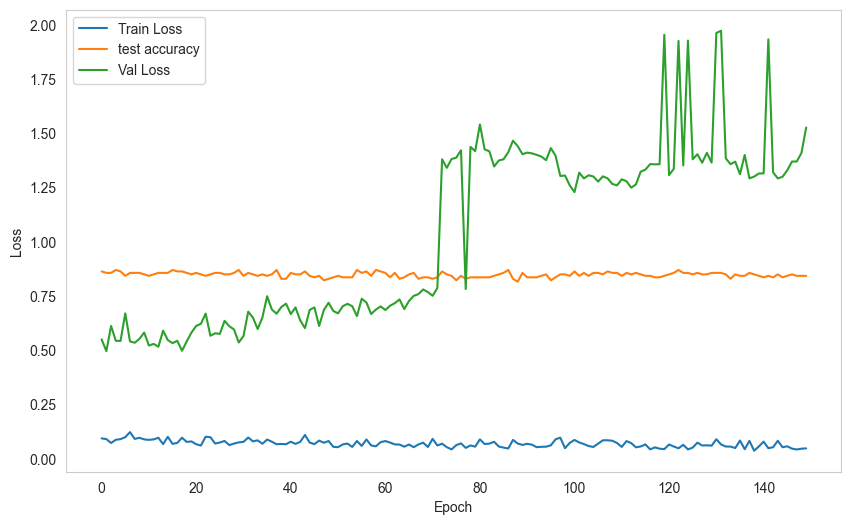

In [128]:
plt.figure(figsize=(10, 6))
plt.plot(trainer.logger.metrics["train_loss"], label="Train Loss")
plt.plot(trainer.logger.metrics["val_acc"], label="test accuracy")
plt.plot(trainer.logger.metrics["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

La value loss qui augmente indique un Sur-apprentissage.

# Question 5
Régression logistique


In [148]:
x_train, x_test, y_train, y_test = train_test_split(
    X_final.values,
    y,
    stratify=stratify_columns,
    test_size=0.2,
    random_state=123
)

In [149]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
y_pred = log_reg.predict(x_test)

c:\Users\enzom\OneDrive\Bureau\MINES\SDD\NN\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [151]:
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred):.3f}")
print(classification_report(y_test_bin, y_pred))

Accuracy: 0.878
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        51
           1       0.91      0.90      0.91        96

    accuracy                           0.88       147
   macro avg       0.86      0.87      0.87       147
weighted avg       0.88      0.88      0.88       147



INFORMATIONS DE BASE
Période couverte: de 2011-01-01 00:00:00 à 2012-12-31 00:00:00
Nombre de jours: 731
Valeurs manquantes dans cnt: 0

Statistiques descriptives de cnt:
count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64


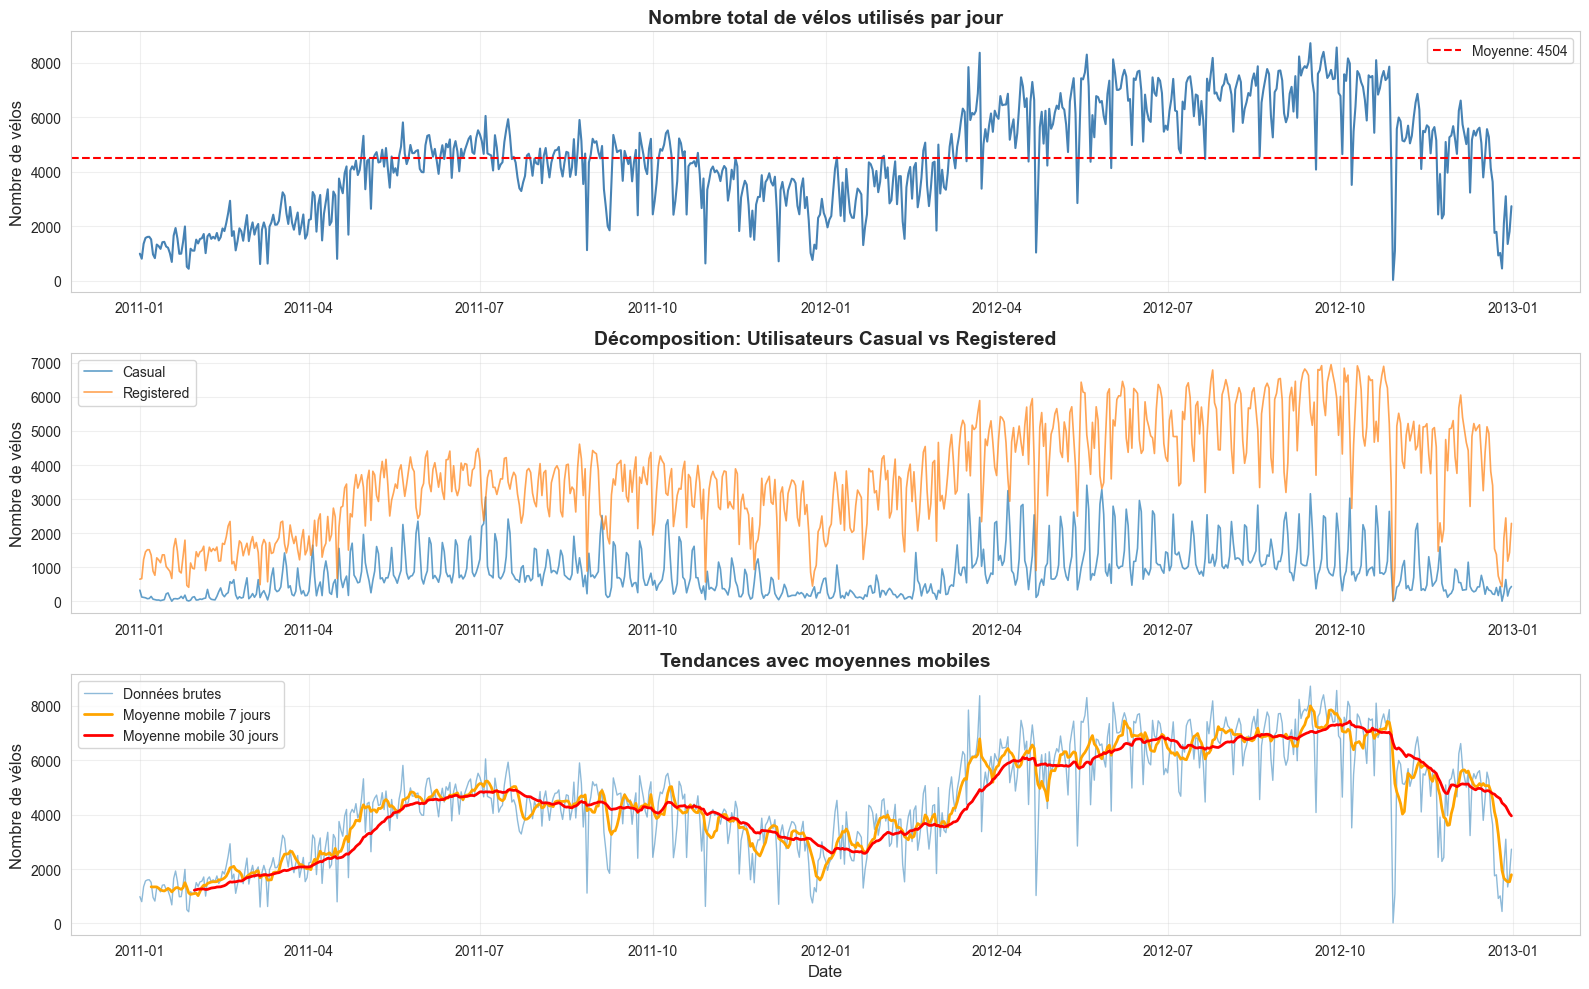

In [152]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

data['dteday'] = pd.to_datetime(data['dteday'])
data = data.sort_values('dteday')
data.set_index('dteday', inplace=True)

print("="*60)
print("INFORMATIONS DE BASE")
print("="*60)
print(f"Période couverte: de {data.index.min()} à {data.index.max()}")
print(f"Nombre de jours: {len(data)}")
print(f"Valeurs manquantes dans cnt: {data['cnt'].isna().sum()}")
print(f"\nStatistiques descriptives de cnt:")
print(data['cnt'].describe())

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Graphique principal
axes[0].plot(data.index, data['cnt'], linewidth=1.5, color='steelblue')
axes[0].set_title('Nombre total de vélos utilisés par jour', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Nombre de vélos', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=data['cnt'].mean(), color='red', linestyle='--', 
                label=f'Moyenne: {data["cnt"].mean():.0f}')
axes[0].legend()

# Casual vs Registered
if 'casual' in data.columns and 'registered' in data.columns:
    axes[1].plot(data.index, data['casual'], label='Casual', 
                 linewidth=1.2, alpha=0.7)
    axes[1].plot(data.index, data['registered'], label='Registered', 
                 linewidth=1.2, alpha=0.7)
    axes[1].set_title('Décomposition: Utilisateurs Casual vs Registered', 
                      fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Nombre de vélos', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

# Moyennes mobiles
axes[2].plot(data.index, data['cnt'], linewidth=1, 
             alpha=0.5, label='Données brutes')
axes[2].plot(data.index, data['cnt'].rolling(window=7).mean(), 
             linewidth=2, label='Moyenne mobile 7 jours', color='orange')
axes[2].plot(data.index, data['cnt'].rolling(window=30).mean(), 
             linewidth=2, label='Moyenne mobile 30 jours', color='red')
axes[2].set_title('Tendances avec moyennes mobiles', 
                  fontsize=14, fontweight='bold')
axes[2].set_ylabel('Nombre de vélos', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Il y a de la saisonnalité, et une tendance haussière. Il faut donc appliquer une différentiation de lag 1 et une autre sur 12 mois. 

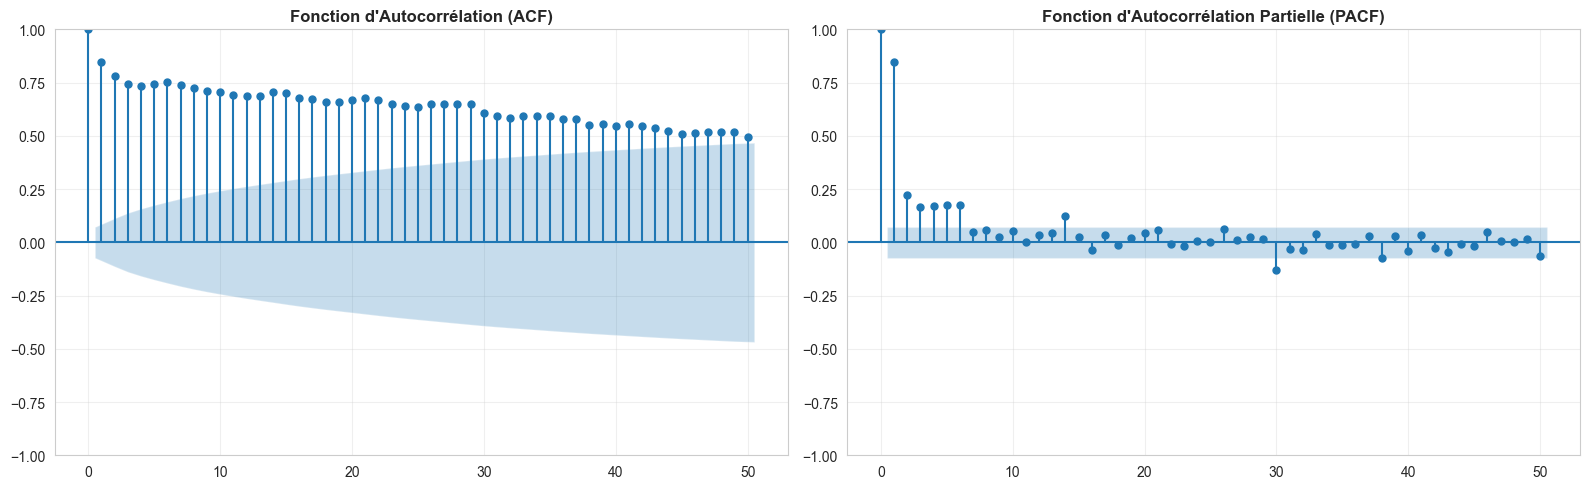

In [ ]:

# 4. ANALYSE DE L'AUTOCORRÉLATION
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(data['cnt'].dropna(), lags=50, ax=axes[0])
axes[0].set_title('Fonction d\'Autocorrélation (ACF)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

plot_pacf(data['cnt'].dropna(), lags=50, ax=axes[1])
axes[1].set_title('Fonction d\'Autocorrélation Partielle (PACF)', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### **Analyse des fonctions d'autocorrélation**

#### **1. Observations**
- **Fonction d'autocorrélation (ACF)** :
  La décroissance exponentielle de l'ACF suggère la présence d'une **composante autorégressive (AR)** dans la série temporelle. Ce comportement est typique d'un processus où les valeurs passées influencent significativement les valeurs futures, avec un effet qui s'atténue progressivement.

- **Fonction d'autocorrélation partielle (PACF)** :
  La PACF devient nulle à partir du **lag 6**, avec des pics significatifs aux lags inférieurs. Cela indique que le processus peut être modélisé par un **modèle AR(6)**, où seuls les 6 lags précédents ont un impact direct sur la valeur actuelle.

#### **2. Interprétation et hypothèses**
- **Modèle ARMA(6,0)** :
  D'après l'analyse de la PACF, un modèle **AR(6)** semble approprié pour capturer la structure de dépendance linéaire de la série.

- **Saisonnalité** :
  - **Effet hebdomadaire** : L'influence du même jour de la semaine précédente suggère une **saisonnalité de lag 7**. Cela peut être capturé par une **différenciation saisonnière** d'ordre 1 avec un lag 7.
  - **Tendance annuelle** : Une saisonnalité annuelle est également suspectée, ce qui pourrait nécessiter une différenciation saisonnière supplémentaire avec un lag 365 (pour des données quotidiennes) ou 52 (pour des données hebdomadaires).

#### **3. Proposition de modélisation**
Pour intégrer ces observations, un modèle **SARIMA** (Seasonal ARIMA) est recommandé :
- **Composante non saisonnière** : AR(6), soit \( p = 6 \).
- **Composante saisonnière** :
  - Différenciation saisonnière d'ordre 1 avec un lag 7, soit \( (P, D, Q)_7 = (0, 1, 0)_7 \).
  - Si la saisonnalité annuelle est confirmée, une différenciation saisonnière supplémentaire avec un lag 365 peut être ajoutée, soit \( (P, D, Q)_{365} = (0, 1, 0)_{365} \).

**Formule finale** :

$SARIMA(6, 0, 0)(0, 1, 0)_7$ ou $SARIMA(6, 0, 0)(0, 1, 0)_7 \times (0, 1, 0)_{365}$


#### **4. Prochaines étapes**
- **Validation du modèle** : Vérifier les résidus pour s'assurer qu'ils sont non corrélés (test de Ljung-Box).
- **Sélection du modèle** : Utiliser des critères comme l'**AIC** ou le **BIC** pour comparer différentes configurations.
- **Prévisions** : Tester le modèle sur un jeu de données de validation pour évaluer sa performance prédictive.

---

MSE: 7312393.80
MAPE: 1.2028


c:\Users\enzom\OneDrive\Bureau\MINES\SDD\NN\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\enzom\OneDrive\Bureau\MINES\SDD\NN\.venv\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


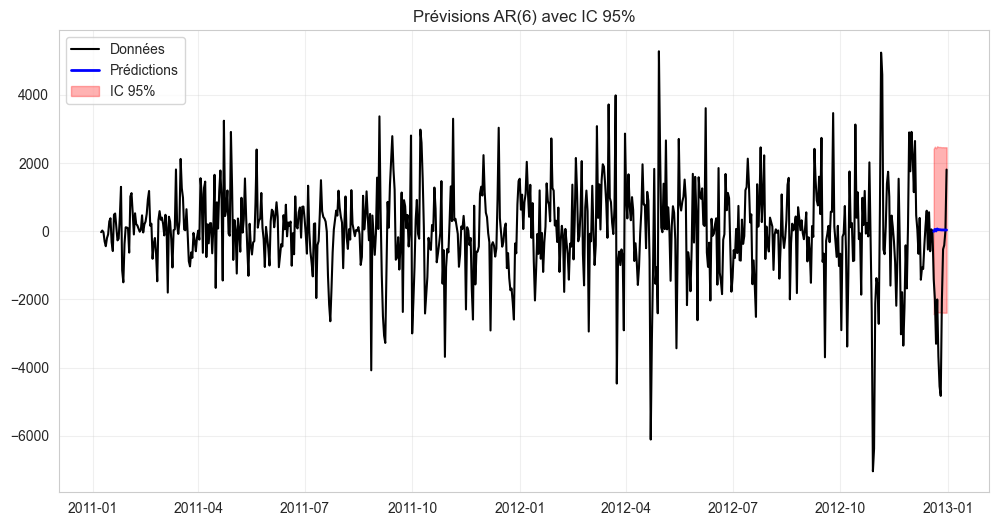

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm

ts_data = data['cnt']
data_diff = ts_data.diff(7).dropna()

# Paramètres
refit = 1
train_window = 21
split_idx = int(len(data_diff) * 0.8)

# Liste pour stocker les prédictions
predictions_rolling = []
actuals = []

# Boucle de prédiction glissante
for i in tqdm(range(split_idx, len(data_diff))):
    # Réajuster le modèle tous les 'refit' pas ou au début
    if i % refit == 0 or i == split_idx:
        # Fenêtre d'entraînement glissante
        train_start = max(0, i - train_window)
        train_data = data_diff.iloc[train_start:i]
        
        # Ajuster le modèle AR(6)
        ar_model = AutoReg(train_data, lags=6)
        ar_fitted = ar_model.fit()
    
    # Prédiction pour le point suivant (1 step ahead)
    pred = ar_fitted.forecast(steps=1)
    predictions_rolling.append(pred[0])
    actuals.append(data_diff.iloc[i])

# Résidus
predictions_rolling = np.array(predictions_rolling)
actuals = np.array(actuals)
residuals = actuals - predictions_rolling

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0,0].plot(actuals, label='Valeurs Réelles', linewidth=1.5)
axes[0, 0].plot(predictions, label='Prédictions AR(6)', linewidth=1.5, linestyle='--')
axes[0, 0].set_title('Valeurs Réelles vs Prédictions AR(6)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(residuals, linewidth=1, color='red')
axes[0, 1].axhline(y=0, color='black', linestyle='--')
axes[0, 1].set_title('Résidus')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(residuals, bins=30, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Distribution des Résidus')

plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('ACF des Résidus')

plt.tight_layout()
plt.show()

In [153]:
data.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# le code au dessus ne fait pas de cross validation et ne prends en compte la saisonnalité de 12 mois !!!! il faut refaire les graphes 